In [132]:
# importing packages to be used in the notebook
import numpy as np
import matplotlib.pyplot as plt
import numba
import warnings
import os
warnings.simplefilter('always', RuntimeWarning)

plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"-"})
plt.rcParams.update({'font.size': 14})

# plt.rcParams.update({'font.size': 15})
# font = {'family': 'serif', 'serif': ['Palatino'], 'size': 15}
# plt.rc('font', **font)
# plt.rc('text', usetex=True)

plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['#000000','#006BA2','#DB444B','#EBB434',
                                                    '#3EBCD2','#379A8B','#9A607F', '#B4BA39', '#754C24']) 

from sequence_jacobian import simple, solved, combine, create_model  # functions
from sequence_jacobian import grids, hetblocks                       # modules
from sequence_jacobian import interpolate
from sequence_jacobian import drawdag
from scipy.interpolate import interp1d
from types import SimpleNamespace

# importing own modules
import hh_housing_v3 # contains the single EGM step 
import utils # contains different useful functions for the model


# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [141]:
# load the HA block
hh = hh_housing_v3.hh_housecons

# add hetinputs to the model
hh1 = hh.add_hetinputs([utils.make_grids, utils.income])

print(f'Inputs: {hh1.inputs}')
print(f'Macro outputs: {hh1.outputs}')
print(f'Micro outputs: {hh1.internals}')

blocks_ss = [hh1, utils.firm, utils.monetary, utils.fiscal, utils.wage_res, 
             utils.mkt_clearing, utils.nkpc_ss, utils.qhouse_lag, utils.gamma_prime]

blocks = [hh1, utils.firm, utils.monetary, utils.fiscal, utils.wage_res, 
          utils.mkt_clearing, utils.nkpc, utils.qhouse_lag, utils.gamma_prime]

hank_ss = create_model(blocks_ss, name="One-Asset HANK SS")
hank = create_model(blocks, name="Housing HANK")

Inputs: ['beta', 'gamma', 'theta', 'sigma', 'qh', 'qh_lag', 'r', 'alpha', 'gamma_p', 'bmin', 'bmax', 'hmax', 'kmax', 'nB', 'nH', 'nK', 'nZ', 'rho_z', 'sigma_z', 'w', 'N', 'Div', 'Tax']
Macro outputs: ['H_BHAT', 'B_BHAT', 'C_BHAT', 'UCE_BHAT', 'CHI']
Micro outputs: ['D', 'Dbeg', 'Pi', 'Vh_bhat', 'Vb_bhat', 'h_bhat', 'b_bhat', 'c_bhat', 'uce_bhat', 'chi', 'Psi1', 'b_bhat_grid', 'h_bhat_grid', 'k_grid', 'e_grid', 'pi_e', 'z_grid']


In [142]:
calibration = {'gamma': 0.8, 'theta': 0.97, 'sigma': 1.0, 'alpha': 0.111, 'bmin': 0.0, 'bmax': 50,
               'hmax': 5.0, 'kmax': 5.0, 'nB': 60, 'nH': 70, 'nK': 60, 'nZ': 3,
               'rho_z': 0.966, 'sigma_z': 0.92, 'N': 1.0, 'Z': 1.0, 'pi': 0.0, 'mu': 1.2,
                'kappa': 0.1, 'rstar': 0.005, 'phi': 1.5, 'nu': 1.0, 'BBAR': 0.25, 'G': 0.0, 'HBAR': 1.0}

calibration['alpha'] = 0.0
calibration['BBAR'] = 0.0
calibration['rstar'] = 0.03/4
calibration['bmin'] = 0.0

unknowns_ss = {'beta': 0.9793721660932323, 'varphi': 0.808535783494474, 'qh': 3.833330693740451}
targets_ss = {'goods_mkt': 0, 'wage_res': 0, 'house_mkt': 0}

ss0 = hank_ss.solve_steady_state(calibration, unknowns_ss, targets_ss, solver="hybr")
print(f"beta: {ss0['beta']}, varphi: {ss0['varphi']}, qh: {ss0['qh']}")

calibration2 = calibration.copy()
# calibration2['rstar'] = 0.005
# calibration2['alpha'] = 0.35
calibration2['gamma'] = 0.7
# unknowns_ss = {'beta': 0.979, 'varphi': 0.809, 'qh': 5.211}
ss0_lowtheta = hank_ss.solve_steady_state(calibration2, unknowns_ss, targets_ss, solver="hybr")

print(f"rstar = {ss0['rstar']}: {ss0['qh']:0.2f}, rstar = {ss0_lowtheta['rstar']:0.2f}: {ss0_lowtheta['qh']:0.2f}")
_, mean_mpc = utils.calc_mpc(ss0, 'hh_housecons')
_, mean_mpc_lowtheta = utils.calc_mpc(ss0_lowtheta, 'hh_housecons')
print(f"Mean MPC: {mean_mpc:0.2f}, Mean MPC low theta: {mean_mpc_lowtheta:0.2f}")

beta: 0.9718782702614316, varphi: 0.8083333333333335, qh: 3.8686150106884654
rstar = 0.0075: 3.87, rstar = 0.01: 3.74
Mean MPC: 0.15, Mean MPC low theta: 0.13


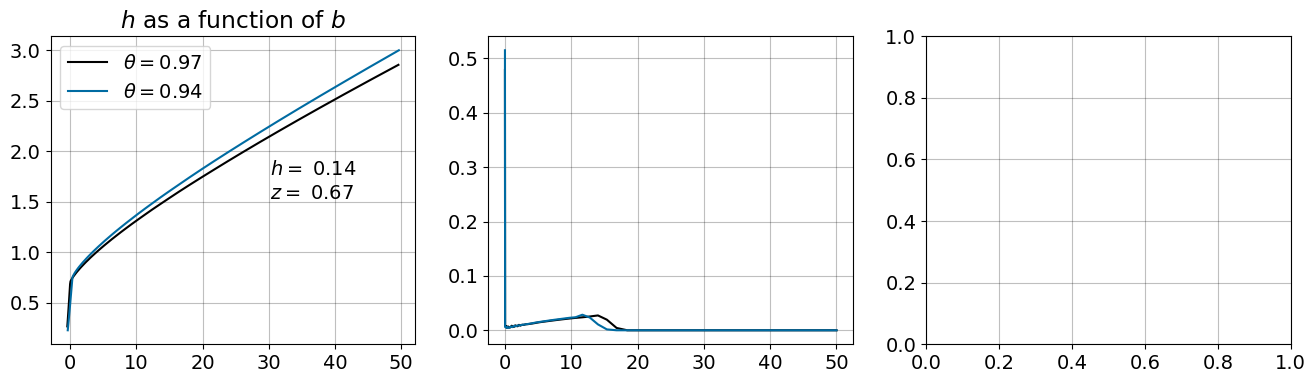

In [136]:
bdmargdist_ll = np.sum(ss0.internals['hh_housecons']['D'], axis=0)
b_margdist_ll = np.sum(bdmargdist_ll,axis=1) # sum out housing

bdmargdist_hl = np.sum(ss0_lowtheta.internals['hh_housecons']['D'], axis=0)
b_margdist_hl = np.sum(bdmargdist_hl,axis=1) # sum out housing

bzmargdist_ll = np.sum(ss0.internals['hh_housecons']['D'], axis=2)
bzmargdist_hl = np.sum(ss0_lowtheta.internals['hh_housecons']['D'], axis=2)

b_endo_ll = ss0.internals['hh_housecons']['b_bhat_grid'][:,None] \
            - ss0['qh_lag']*ss0['gamma']*ss0.internals['hh_housecons']['h_bhat_grid'][None,:]

b_endo_hl = ss0_lowtheta.internals['hh_housecons']['b_bhat_grid'][:,None] \
            - ss0_lowtheta['qh_lag']*ss0_lowtheta['gamma']*ss0_lowtheta.internals['hh_housecons']['h_bhat_grid'][None,:]

z_point = 1
h_point = 10

fig, ax = plt.subplots(1, 3, figsize=(16,4))
ax = ax.flatten()

ax[0].plot(b_endo_ll[:,h_point], ss0.internals['hh_housecons']['h_bhat'][z_point,:,h_point], label = r'$\theta = 0.97$')
ax[0].plot(b_endo_hl[:,h_point], ss0_lowtheta.internals['hh_housecons']['h_bhat'][z_point,:,h_point], label = r'$\theta = 0.94$')
ax[0].legend()
ax[0].set_title(r'$h$ as a function of $b$')
ax[0].text(0.6, 0.6, f"$h =$ {ss0.internals['hh_housecons']['h_bhat_grid'][h_point]:.2f}", 
         horizontalalignment='left', verticalalignment='top', transform=ax[0].transAxes)
ax[0].text(0.6, 0.52, f"$z =$ {ss0_lowtheta.internals['hh_housecons']['z_grid'][z_point]:.2f}", 
         horizontalalignment='left', verticalalignment='top', transform=ax[0].transAxes)

ax[1].plot(ss0_lowtheta.internals['hh_housecons']['b_bhat_grid'], b_margdist_ll, label = r'$\theta = 0.97$')
ax[1].plot(ss0_lowtheta.internals['hh_housecons']['b_bhat_grid'], b_margdist_hl, label = r'$\theta = 0.94$')

plt.show()

In [137]:
# General settings for the model
T = 300
unknowns = ['pi', 'w', 'N', 'qh']
targets = ['nkpc_res', 'asset_mkt', 'wage_res', 'house_mkt']
exogenous = ['rstar', 'Z', 'gamma']

ss = hank.steady_state(ss0)
ss_lowtheta = hank.steady_state(ss0_lowtheta)

for k in ss0.keys():
    assert np.all(np.isclose(ss[k], ss0[k]))

In [138]:
rho_r, sig_r = 0.6, 0.01
dr = sig_r * rho_r ** (np.arange(T))
rstar_shock = {"rstar": dr}

input_list = ['qh', 'r', 'qh_lag', 'Tax', 'Div', 'N', 'w']
decomp = SimpleNamespace()
decomp_lowtheta = SimpleNamespace()

Js = {'hh1': hh1.jacobian(ss, inputs = input_list, 
                          outputs=['C_BHAT', 'H_BHAT', 'B_BHAT', 'CHI'], T=T)}

Js_lowtheta = {'hh1': hh1.jacobian(ss_lowtheta, inputs = input_list, 
                          outputs=['C_BHAT', 'H_BHAT', 'B_BHAT', 'CHI'], T=T)}

irf = hank.solve_impulse_linear(ss, unknowns, targets, rstar_shock, Js = Js, verbose = False)
irf_lowtheta = hank.solve_impulse_linear(ss_lowtheta, unknowns, targets, rstar_shock, Js = Js_lowtheta, verbose = False)

for k in input_list:
    setattr(decomp, f'dC_d{k}', Js['hh1']['C_BHAT'][k] @ irf[k])
    setattr(decomp_lowtheta, f'dC_d{k}', Js_lowtheta['hh1']['C_BHAT'][k] @ irf_lowtheta[k])

KeyError: 'qh_lag'

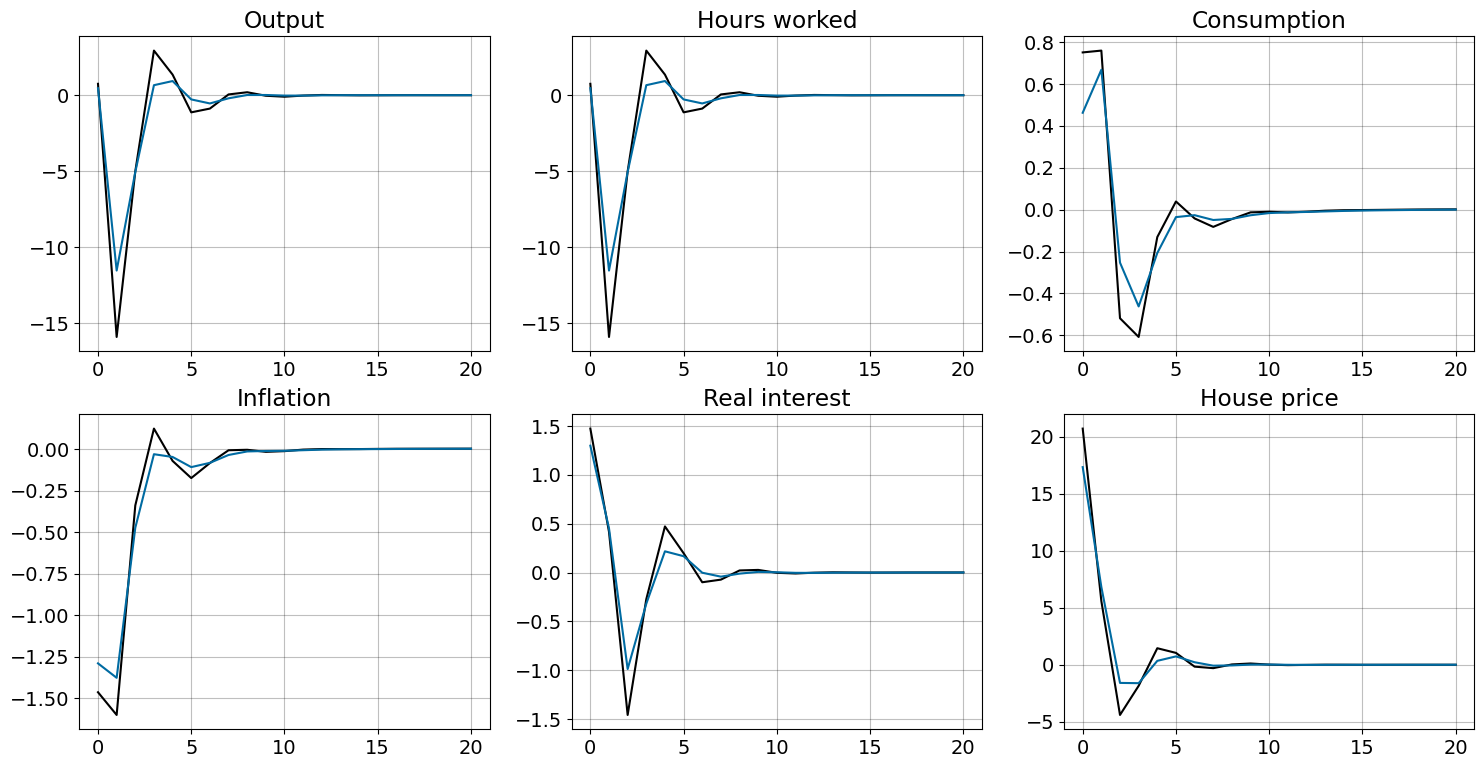

In [139]:
fig, ax = plt.subplots(2, 3, figsize=(18,9))
ax = ax.flatten()

var_name = {'Y': 'Output', 'N': 'Hours worked', 'C_BHAT': 'Consumption', 
            'pi': 'Inflation', 'r': 'Real interest', 'qh': 'House price'}

# for i, var in enumerate(var_plot):
for i, (key, value) in enumerate(var_name.items()):   
    ax[i].plot(100*irf[key][:21])
    ax[i].plot(100*irf_lowtheta[key][:21])
    ax[i].set_title(var_name[key])

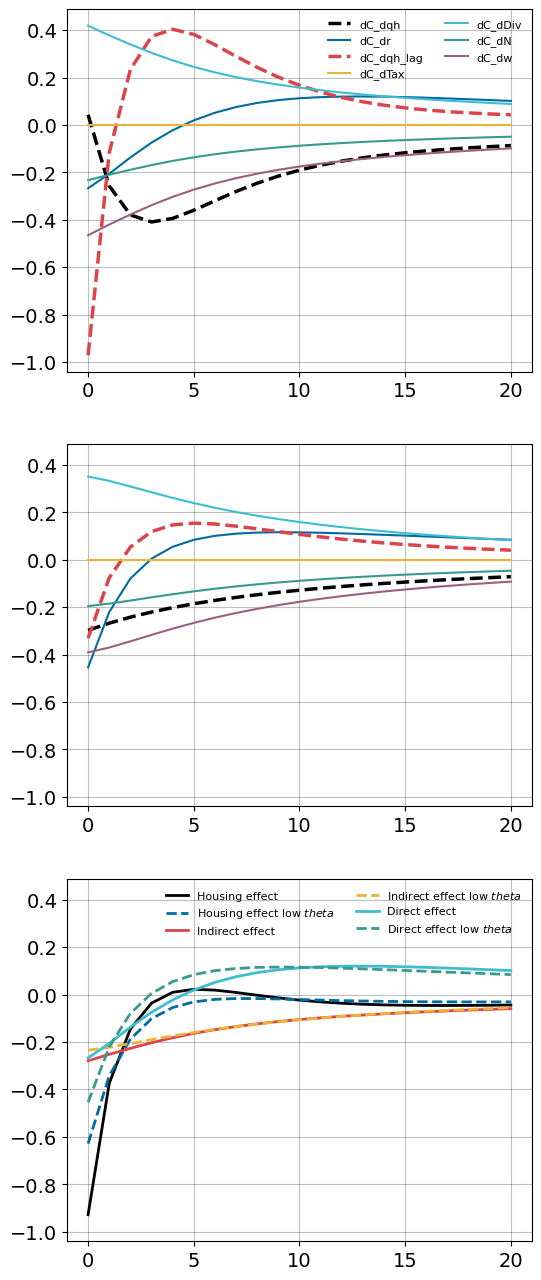

In [98]:
decomp_dict = vars(decomp)
decomp_dict_lowtheta = vars(decomp_lowtheta)

total_response_ll = 0
total_response_hl = 0

for (key, value) in decomp_dict.items():
    total_response_ll += value

for (key, value) in decomp_dict_lowtheta.items():
    total_response_hl += value

housing_effect = decomp.dC_dqh + decomp.dC_dqh_lag
housing_effect_hl = decomp_lowtheta.dC_dqh + decomp_lowtheta.dC_dqh_lag
indirect_effect = decomp.dC_dN + decomp.dC_dTax + decomp.dC_dDiv + decomp.dC_dw
indirect_effect_hl = decomp_lowtheta.dC_dN + decomp_lowtheta.dC_dTax + decomp_lowtheta.dC_dDiv + decomp_lowtheta.dC_dw
direct_effect = decomp.dC_dr
direct_effect_hl = decomp_lowtheta.dC_dr

ncols = 1
nrows = 3
fig, ax = plt.subplots(nrows, ncols, figsize=(6,16), sharey=True)
ax = ax.flatten()

for (key, value) in decomp_dict.items():
    if key != 'dC_dqh' and key != 'dC_dqh_lag':
        ax[0].plot(100*value[:21], label = key)
    else:
        ax[0].plot(100*value[:21], label = key, linestyle='--', linewidth=2.5)
ax[0].legend(frameon=False, ncols = 2, fontsize=8)

for (key, value) in decomp_dict_lowtheta.items():
    if key != 'dC_dqh' and key != 'dC_dqh_lag':
        ax[1].plot(100*value[:21], label = key)
    else:
        ax[1].plot(100*value[:21], label = key, linestyle='--', linewidth=2.5)

lw = 2.0
ax[2].plot(100*housing_effect[:21], label = 'Housing effect', linewidth=lw)
ax[2].plot(100*housing_effect_hl[:21], label = r'Housing effect low $theta$', linestyle='--', linewidth=lw)
ax[2].plot(100*indirect_effect[:21], label = 'Indirect effect', linewidth=lw)
ax[2].plot(100*indirect_effect_hl[:21], label = r'Indirect effect low $theta$', linestyle='--', linewidth=lw)
ax[2].plot(100*direct_effect[:21], label = 'Direct effect', linewidth=lw)
ax[2].plot(100*direct_effect_hl[:21], label = r'Direct effect low $theta$', linestyle='--', linewidth=lw)

plot_total = False
if plot_total:
    ax[2].plot(100*total_response_ll[:21], label = 'Total response', linewidth=lw)
    ax[2].plot(100*total_response_hl[:21], label = r'Total response low $theta$', linestyle='--', linewidth=lw)
    ax[2].plot(100*irf['C_BHAT'][:21], label = 'Consumption', linestyle=':', linewidth=lw)
    ax[2].plot(100*irf_lowtheta['C_BHAT'][:21], label = 'Consumption low $theta$', linestyle=':', linewidth=lw)

ax[2].legend(frameon=False, ncols = 2, fontsize=8)

In [111]:
calibration2['gamma'] = 0.7
ss0_lowtheta = hank_ss.solve_steady_state(calibration2, unknowns_ss, targets_ss, solver="hybr")
ss_lowtheta = hank.steady_state(ss0_lowtheta)

In [112]:
rho_r, sig_r = 0.8, 0.15
dr = sig_r * rho_r ** (np.arange(T))
shock_pos = {"gamma": dr}
shock_neg = {"gamma": -dr}

input_list = ['qh', 'r', 'qh_lag', 'Tax', 'Div', 'N', 'w']
decomp = SimpleNamespace()
decomp_lowtheta = SimpleNamespace()

# Js = {'hh1': hh1.jacobian(ss, inputs = input_list, 
#                           outputs=['C_BHAT', 'H_BHAT', 'B_BHAT', 'CHI'], T=T)}

# Js_lowtheta = {'hh1': hh1.jacobian(ss_lowtheta, inputs = input_list, 
#                           outputs=['C_BHAT', 'H_BHAT', 'B_BHAT', 'CHI'], T=T)}

irf_pos = hank.solve_impulse_nonlinear(ss_lowtheta, unknowns, targets, shock_pos, verbose = False)
irf_neg = hank.solve_impulse_nonlinear(ss_lowtheta, unknowns, targets, shock_neg, verbose = False)

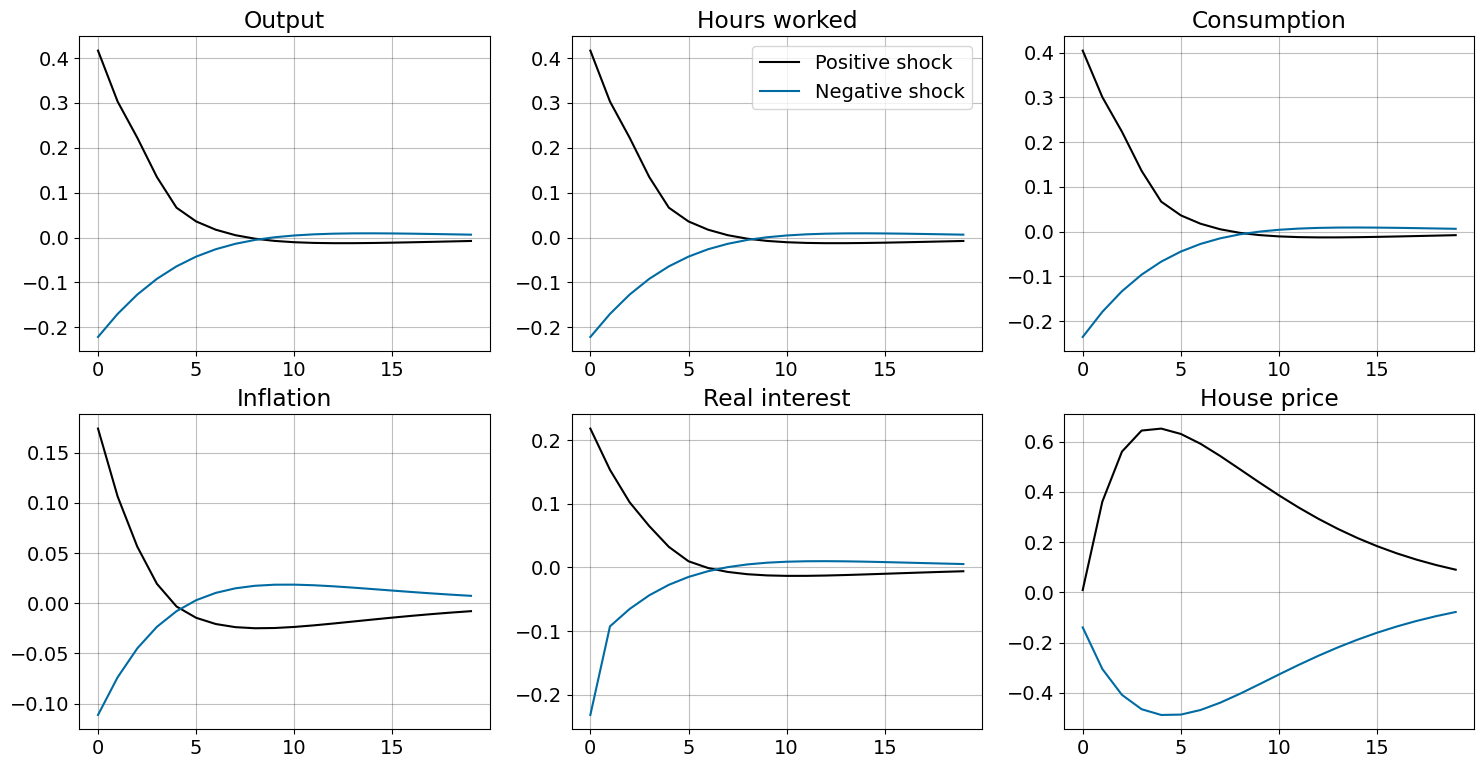

In [118]:
fig, ax = plt.subplots(2, 3, figsize=(18,9))
ax = ax.flatten()

var_name = {'Y': 'Output', 'N': 'Hours worked', 'C_BHAT': 'Consumption', 
            'pi': 'Inflation', 'r': 'Real interest', 'qh': 'House price'}

# for i, var in enumerate(var_plot):
for i, (key, value) in enumerate(var_name.items()):   
    ax[i].plot(100*irf_pos[key][1:21])
    ax[i].plot(100*irf_neg[key][1:21])
    ax[i].set_title(var_name[key])
    if i == 1:
        ax[i].legend(['Positive shock', 'Negative shock'])